# TM10007 Assignment Head and Neck cancer Radiomics

Marie-Claire Doornbos (4492951)
Julia Holdorp (4561651)
Quinten Mank (4336615)
Ylva Weeda (4556038)

 

# Radiomics Pipeline

In this assignment a complete Radiomics Pipeline is composed. After importing all required modules in section 1 the data is loaded and preprocessing methods are defined.

Subsequently, the data is seperated into a train and a test set according to the experimental setup explained below. A standard scaler is used to standardize the training set. The training set is fitted and transformed, while the test set is only transformed (Never touch your test set!!).

Feature selection is applied through either LASSO or PCA, resulting in two different pipelines. After feature selection the following classifiers are applied: Logistic Regression, KNearestNeighbor, Random Forest and Support Vector Machine. To split the data set in a train and test set, for our experimental setup, a repeated KFold cross validation is done, using 5 folds and 50 repeats. In order to find the optimal hyperparameters for each classifier, a random grid search is executed, in which a second cross validation is applied. Inside this cross validation, the training set is once again splitted into a training set and a validation set. The optimal parameters for each classifier are fitted on the train set. 

To evaluate the machine learning algoritm for the prediction of the T-score in head and neck cancer patients, different performance measures are used. The performance is determined by the accuracy, sensitivity and specificity. A ROC is plotted for each classifier,in which performance can be evaluated by the area under the curve (AUC). The performance measures for all classifiers are visualized in a boxplot.

Finally, a learning curve is plotted to evaluate the complexity of the dataset vs. the complexity of the model and to asses possible overfitting. 


In [2]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Importing Modules

In [1]:
# General Packages
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import interp
from scipy.stats import randint

# Load Data
from hn.load_data import load_data

# Classifiers & Kernels
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Pre-processing
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

# Model Selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean

# Evaluation
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

#Learning curves
from heapq import nlargest
from sklearn.model_selection import learning_curve


Defining output path 

In [2]:
output_path = os.getcwd()
print(output_path)


/Users/marie-clairedoornbos/Documents/Master_Jaar_1/TM10007/Groepsopdracht/TM10007_PROJECT


## 1. Data loading and Preprocessing
The Head and Neck cancer dataset is loaded into the script. If the dataset contains any missing values or NaN, the missing value is imputed with the mean of the feature in question. The data is scaled using a StandardScaler. Eventually, the data is split into feature values and labels (high risk (1) or low risk (0)). The amount of high-risk and low-risk patients is printed as an output. Features that have a standard deviation that equals zero, are considered non-distinctive and are removed from the feature values. The non-distinctive features are also printed as an output.



1.1 Load data

In [3]:
def load_check_data():
    '''
    Check if the datafile exists and is valid before reading. Impute missing data.
    '''
    # Check whether datafile exists
    try:
        data = load_data()
        print(f'The number of samples: {len(data.index)}')
        print(f'The number of columns: {len(data.columns)}')
    except FileNotFoundError:
        return print("The csv datafile does not exist"), sys.exit()
    except pd.errors.ParserError:
        return print('The csv datafile is not a proper csv format.'
                     'Please provide a data file in csv format.'), sys.exit()
    # Check whether data is missing.
    # Impute missing or NaN datapoints are with the average of that feature.
    if data.isnull().values.any():
        column_mean = data.mean()
        data = data.fillna(column_mean)
        print('In the csv data file, some values are missing or NaN.'
              'These missing values are replaced by the mean of that feature.')
    return data
data = load_check_data()



The number of samples: 113
The number of columns: 160


1.2 Extract feature values and labels

In [4]:
# Extract labels from data
labels = data.loc[:,['label']].values

# Low risk patients receive the label 0 and high risk the label 1
labels = [item if item!='T12' else 0 for item in labels]
labels = [item if item!='T34' else 1 for item in labels]
labels = np.array(labels)

# Number of high and low risk patients is printed
print(f'Number of high risk patients: {np.count_nonzero(labels)}')
print(f'Number of low risk patients: {len(labels) - np.count_nonzero(labels)}')

# Drop features that are not distinctive (standard deviation equals 0)
data_features = data.drop(['label'], axis=1)
columns = data_features.columns
std = data_features[columns].std()
not_distinctive = std[std==0].index
data_features = data_features.drop(not_distinctive, axis=1)
print(f'\nFeatures that were considered non-distinctive : {not_distinctive}')

# Extract features from data
features = data_features.values
print(f'Number of samples: {features.shape[0]}')
print(f'Resulting number of features: {features.shape[1]}')


Number of high risk patients: 55
Number of low risk patients: 58

Features that were considered non-distinctive : Index(['tf_LBP_peak_R15_P36', 'tf_LBP_peak_R3_P12'], dtype='object')
Number of samples: 113
Resulting number of features: 157


1.3 Check for outliers

In [5]:
# Detecting outliers using the interquartile range
data_check = data.drop(['label'], axis=1)
Q1 = data_check.quantile(0.25)
Q3 = data_check.quantile(0.75)
IQR = Q3 - Q1

#couting the outliers
outliers = (data_check < (Q1 - 1.5 * IQR)) |(data_check > (Q3 + 1.5 * IQR))
number_of_outliers= outliers.sum()

#printing the number of outliers per column
print(f'The number of outliers is printed per column : \n{number_of_outliers}')

The number of outliers is printed per column : 
hf_energy               8
hf_entropy              0
hf_kurtosis             5
hf_max                  8
hf_mean                 1
                       ..
tf_NGTDM_Busyness      20
tf_NGTDM_Coarseness     0
tf_NGTDM_Complexity    15
tf_NGTDM_Contrast      20
tf_NGTDM_Strength      16
Length: 159, dtype: int64


1.4 Definition to scale the dataset

In [6]:
def scale_data(x, y):
    """
    Scale data with Standard scaler
    """
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x)
    x_test = scaler.transform(y)
    return x_train, x_test



1.5 Splitting the data in training and test
    

In [7]:
def split_sets(x, y):
    """
    Splits the features and labels into a training set (80%) and test set (20%).
    Splitting in the train and test set is shown to provide insight into our method 
    and is used to compute the principal components and alpha for LASSO estimator. 
    """
    # Use repeated stratified KFold
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=None)
    
    # Splitting data into test and training set
    for train_index, test_index in crss_val.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Scale the data by fitting on the training set and transforming the test set
        x_train, x_test = scale_data(x_train, x_test)
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = split_sets(features, labels)

# 2. Feature selection
Two different feature selection/extraction tools will be used to find the most distinctive and informative features for analysis. 
1. LASSO (least absolute shrinkage and selection operator): penalizes the absolute sum of weights. 
2. PCA (principal component analysis): finds the directions in which the variance in the highest and rotates data to match. The amount of principal components are calculated base on the train set. 

These two methods will be evaluated and eventually one method will be applied. 


2.1 Compute LASSO 

In [8]:
# Tuning alpha parameter for optimal feature selection with LASSO
test_scores = []
a_max=0
n_alphas = 100
alphas = np.logspace(-2,0,num=n_alphas)

# Loop over range of alphas
for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a)
    clf.fit(pd.DataFrame(x_train).fillna(0), y_train)
        
    # Compute determination coefficient and selecting best alpha
    test_score = clf.score(x_test, y_test)
    if test_score > a_max:
         a_max = test_score
         best_alpha = a
 
# The value used for alpha = 0.040  

def apply_lasso(x1, y, x2, data):
    """
    Apply L1 regularization with best alpha
    """
    # Apply LASSO with calculated best alpha
    lasso = SelectFromModel(estimator=Lasso(alpha=0.040))
    lasso.fit((pd.DataFrame(x1).fillna(0)),y)
    lasso.get_support()
    selected_feat = data.columns[(lasso.get_support())]
    #print('total features: {}'.format((x1.shape[1])))
    #print('features with coefficients shrank to zero: {}'.format(np.sum(lasso.estimator_.coef_ == 0))) 
    
    # Get list of removed features and remove from training and test set
    removed_feats = [(lasso.estimator_.coef_ == 0).ravel().tolist()]
    x_train = lasso.transform(pd.DataFrame(x1).fillna(0))
    x_test = lasso.transform(pd.DataFrame(x2).fillna(0))
    return x_train, x_test

x_train_L1, x_test_L1 = apply_lasso(x_train, y_train, x_test, data_features)
print('total features: {}'.format((x_train_L1.shape[1])))
#print('features with coefficients shrank to zero: {}'.format(np.sum(lasso.estimator_.coef_ == 0)))

total features: 19


2.2 Compute PCA

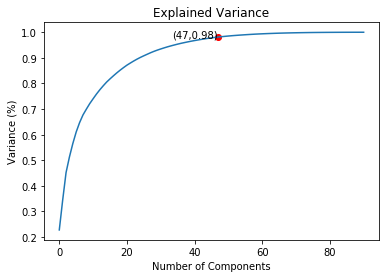

In [9]:
# Computing number of principal components of scaled train data 
pca = PCA().fit(x_train)

# Plot number of components vs. variance, 47 components are used to apply PCA
plt.figure()
plt.scatter(47, 0.98, color='r')
plt.text(47, 0.98, '(47,0.98)', horizontalalignment='right')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()


def apply_pca(x, y):
    """
    Apply PCA with 47 components to data
    """
    pca = PCA(n_components=47)
    pca.fit(x)
    x_train = pca.transform(x)
    x_test = pca.transform(y)
    return x_train, x_test



## 3. Validation
In this section the feature selection methods, LASSO and PCA, are compared with eachother and evaluated on the training set. From this, one feature selection method will be chosen to apply to the final pipeline. 
Furthermore, for each classifier the hyperparameter optimalization method is evaluated to determine wheter a Randomsearch yields a better performing model.


3.1. Classifier Pipeline for Validation

Baseline, with PCA and with LASSO without Hyperparameters optimization

In [10]:
# Define Classifiers
clsfs = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True)]
names = ['Logistic Regression', 'kNN', 'Random Forest', 'SVM']

baseline_accuracy = []
baseline_PCA = []
baseline_L1 = []
for clf, name in zip(clsfs, names):
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 
    results_rs = []
    results_PCA = []
    results_L1 = []
    for train_index, test_index in crss_val.split(features, labels):

        x_train, x_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Scale data with Standard Scalar
        x_train, x_test = scale_data(x_train, x_test)

        # Apply PCA to data
        x1_train, x1_test = apply_pca(x_train, x_test)
 
        # Apply L1 to data
        x2_train, x2_test = apply_lasso(x_train, y_train, x_test, data_features)

        # Fit models and get performance scores       
        model_base = clf.fit(x_train, y_train)
        results_base = cross_val_score(model_base, x_train, y_train, cv=5)
        model_PCA = clf.fit(x1_train, y_train)
        results_PCA = cross_val_score(model_PCA, x1_train, y_train, cv=5)
        model_L1 = clf.fit(x2_train, y_train)
        results_L1 = cross_val_score(model_L1, x2_train, y_train, cv=5)

    # Get mean accuracies
    results_base = mean(results_base)
    baseline_accuracy.append(results_base)
    results_PCA = mean(results_PCA)
    baseline_PCA.append(results_PCA)
    results_L1 = mean(results_L1)
    baseline_L1.append(results_L1)

# Create dataframe and append results 
base_model = pd.DataFrame()
base_model['Classifier'] = ['LR', 'KNN', 'RF', 'SVM']
base_model['Baseline Accuracy'] = baseline_accuracy
base_PCA = pd.DataFrame()
base_PCA['PCA Accuracy'] = baseline_PCA
base_L1 = pd.DataFrame()
base_L1['L1 Accuracy'] = baseline_L1


Baseline, with PCA and with LASSO with Hyperparameter optimization

In [11]:
# Define parameter distributions for Randomized Search
param_distributions = [{}, {'n_neighbors': randint(1, 20)}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 17), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]
HP_accuracy = []
HP_PCA = []
HP_L1 = []
for clf, name, param_dist in zip(clsfs, names, param_distributions):
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 
    results_rs = []
    results_PCA = []
    results_L1 = []
    # Split dataset in train and test set thourgh cross validation
    for train_index, test_index in crss_val.split(features, labels):
        x_train, x_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Scale data with Standard Scalar
        x_train, x_test = scale_data(x_train, x_test)

        # Apply PCA to data
        x1_train, x1_test = apply_pca(x_train, x_test)

        # Apply L1 to data
        x2_train, x2_test = apply_lasso(x_train, y_train, x_test, data_features)

        # RandomizedSearch for optimalization Hyperparameters and fit models
        random_search1 = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
        model_randomsearch_base = random_search1.fit(x_train, y_train)
        random_search2 = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
        model_randomsearch_PCA = random_search2.fit(x1_train, y_train)
        random_search3 = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
        model_randomsearch_L1 = random_search3.fit(x2_train, y_train)
        
        # Get performance scores
        result_rs = model_randomsearch_base.best_score_
        results_rs.append(result_rs)
        result_PCA = model_randomsearch_PCA.best_score_
        results_PCA.append(result_PCA)
        result_L1 = model_randomsearch_L1.best_score_
        results_L1.append(result_L1)

    # Get mean accuracies
    results_rs = mean(results_rs)
    HP_accuracy.append(results_rs)
    results_PCA = mean(results_PCA)
    HP_PCA.append(results_PCA)
    results_L1 = mean(results_L1)
    HP_L1.append(results_L1)

# Create dataframe and append results 
HP_acc = pd.DataFrame()
HP_acc['Accuracy HP'] = HP_accuracy
HP_PC = pd.DataFrame()
HP_PC['Accuracy PCA HP'] = HP_PCA
HP_L = pd.DataFrame()
HP_L['Accuracy L1 HP'] = HP_L1


KeyboardInterrupt: 

Compare results of Feature Selection methods and Hyperparameters optimazation

In [13]:
# Concenate Dataframes to one Dataframe
compareModels = pd.concat([base_model, HP_acc], axis=1)
compareModels['Improvement Base %']= (100 *(compareModels['Accuracy HP'] - compareModels['Baseline Accuracy'])/compareModels['Baseline Accuracy'])
compareModels = pd.concat([compareModels, base_PCA, HP_PC], axis=1)
compareModels['Improvement PCA %']= (100 *(compareModels['Accuracy PCA HP']- compareModels['PCA Accuracy'])/compareModels['PCA Accuracy'])
compareModels = pd.concat([compareModels,base_L1, HP_L], axis=1)
compareModels['Improvement L1 %']= (100 *(compareModels['Accuracy L1 HP']- compareModels['L1 Accuracy'])/compareModels['L1 Accuracy'])

#compareModels.save()
compareModels.to_csv(str(output_path) + "/" + 'Comparing baseline with hyperparameter optimization and feature selection', index=False)

# Visualize Dataframe
pprint(compareModels.round(2))

Classifier  Baseline Accuracy  Accuracy HP  Improvement Base %  \
0         LR               0.77         0.71               -7.97   
1        KNN               0.57         0.67               16.50   
2         RF               0.73         0.73                0.68   
3        SVM               0.63         0.74               18.15   

   PCA Accuracy  Accuracy PCA HP  Improvement PCA %  L1 Accuracy  \
0          0.74             0.68              -7.30         0.77   
1          0.56             0.66              17.25         0.80   
2          0.64             0.70               9.58         0.80   
3          0.64             0.70               9.99         0.82   

   Accuracy L1 HP  Improvement L1 %  
0            0.83              8.10  
1            0.78             -2.35  
2            0.76             -5.64  
3            0.79             -3.62  


3.2. LASSO vs. PCA

From the results of the Radiomics Pipeline on the training/validation set, a large difference between accuracy scores of PCA and LASSO feature selection can be observed. Both at baseline and with hyperparameter optimization LASSO seems to perform notably better. Despite the small effect of the hyperparameter optimization combined with LASSO, based on the accuracy the LASSO is preferred. For further evaluation, LASSO will be applied as feature selection method. 

3.3. Hyperparameters optimalisation vs. no optimalisation

For evaluation of hyperparameter optimization, the Logistic Regression classifier is not considered since default parameters were applied for all methods. At baseline, the other classifiers show an improvement in accuracy when hyperparameters are optimized, especially k-Nearest Neighbor and Suppot Vector Machine. Therefore, for future evaluation, hyperparameters are optimized according to the Randomized Search method. 

3.4. Selection of Classifiers

From the results of the Radiomics Pipeline of the training/validation set, no clear distinction can be made between the accuracy scores of the classifier, when applying LASSO as feature selection method. Therefore, for further evaluation, all classifier are included. Finally, based on the performance of the Radiomics Pipeline on the test set, a conclusion about the applictation of these classifiers will be made. 

## 4. Evaluation of the Model

Based on the validation of the model on the training set, the best model is composed. In this section the performance of the model is evaluated on the test set, to see how accurate the model is able to predict the T stage in Head and Neck Cancer. An accuracy of 70% is pursued.

The area under the ROC curve is plotted and accuracy, sensitivity and specificity are computed using a confusion matrix. All performance measures are visualized in a boxplot. 


4.1. Compute Performance Measures

In [12]:
def compute_performance(model, x, y):
    """ 
    Get Performances on test set
    """
    base_fpr = np.linspace(0, 1, 101)
    # Predict labels for dataset
    prediction = model.predict(x)

    # Create Dataframe and confusion matrix
    performance_scores = pd.DataFrame()
    auc_scores.append(roc_auc_score(y, prediction))
    conf_mat = confusion_matrix(y, prediction)
    total = sum(sum(conf_mat))

    # Calculate performance measures and append to dataframe
    accuracies.append((conf_mat[0, 0]+conf_mat[1, 1])/total)
    sensitivities.append(conf_mat[0, 0]/(conf_mat[0, 0]+conf_mat[0, 1]))
    specificities.append(conf_mat[1, 1]/(conf_mat[1, 0]+conf_mat[1, 1]))
    performance_scores['Accuracy'] = accuracies
    performance_scores['AUC'] = auc_scores
    performance_scores['Sensitivity'] = sensitivities
    performance_scores['Specificity'] = specificities

    # Compute variables for ROC curve
    predicted_probas = model.predict_proba(x)[:, 1]
    fpr, tpr, _ = roc_curve(y, predicted_probas)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    return performance_scores, tprs, aucs

    

4.2 Plot ROC curves

In [13]:
def plot_ROC(tprs, aucs, name, directory):
    """
    Plot ROC curve with AUC for each classifier
    """
    base_fpr = np.linspace(0, 1, 101)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.figure(figsize=(12, 8))
    plt.plot(base_fpr, mean_tprs, 'c', alpha=0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='c', alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=0.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.title(f'Receiver operating characteristic (ROC) curve {name}')
    plt.grid()
    plt.show()
    return



4.3 Generate Boxplot

In [14]:
def create_boxplot(performance_clf, names):
    """
    Create boxplot of performance measures for all classifiers
    """
    # Store performance measures for each classifier in dataframe
    data1 = pd.DataFrame(performance_clf[0], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=1)
    data2 = pd.DataFrame(performance_clf[1], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=2)
    data3 = pd.DataFrame(performance_clf[2], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=3)
    data4 = pd.DataFrame(performance_clf[3], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=4)
    
    # Fuse dataframes
    cdf = pd.concat([data1, data2, data3, data4])
    mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Index'])

    # Generate boxplot
    ax = sns.boxplot(x="Location", y="value", hue="Index", data=mdf)    
    plt.xticks([0, 1, 2, 3], names)
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Performance')
    plt.show()
    return

4.4 Classifier Pipeline for evaluation on test set

Performance Logistic Regression Classifier:
      Accuracy       AUC  Sensitivity  Specificity
mean  0.723103  0.722955     0.737727     0.708182


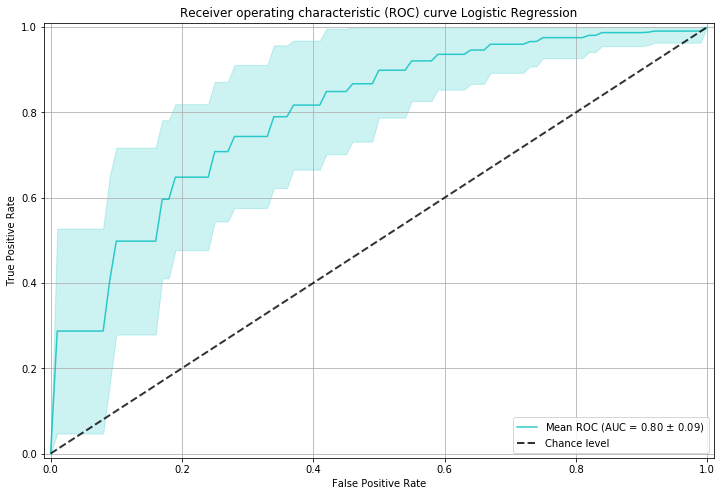

Performance kNN Classifier:
      Accuracy       AUC  Sensitivity  Specificity
mean  0.724802  0.725455          0.7     0.750909


<Figure size 432x288 with 0 Axes>

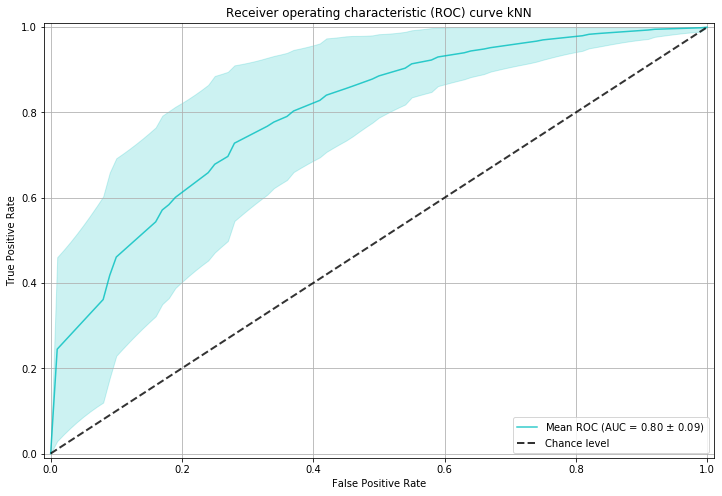

Performance Random Forest Classifier:
      Accuracy       AUC  Sensitivity  Specificity
mean    0.7283  0.728561     0.722576     0.734545


<Figure size 432x288 with 0 Axes>

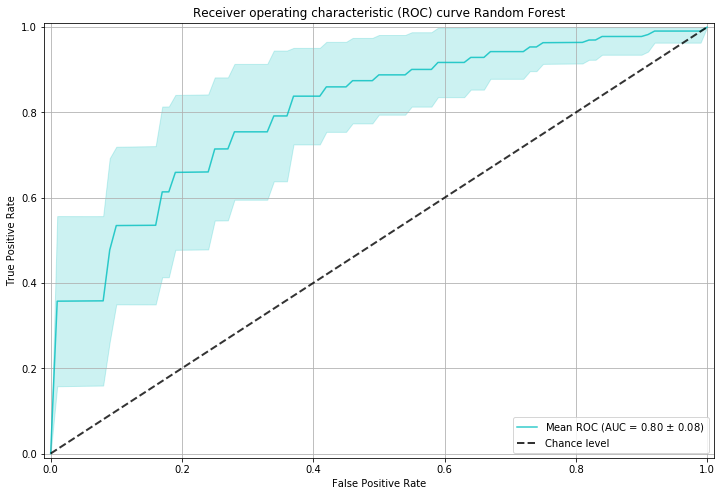

Performance SVM Classifier:
      Accuracy       AUC  Sensitivity  Specificity
mean  0.675988  0.675833     0.677121     0.674545


<Figure size 432x288 with 0 Axes>

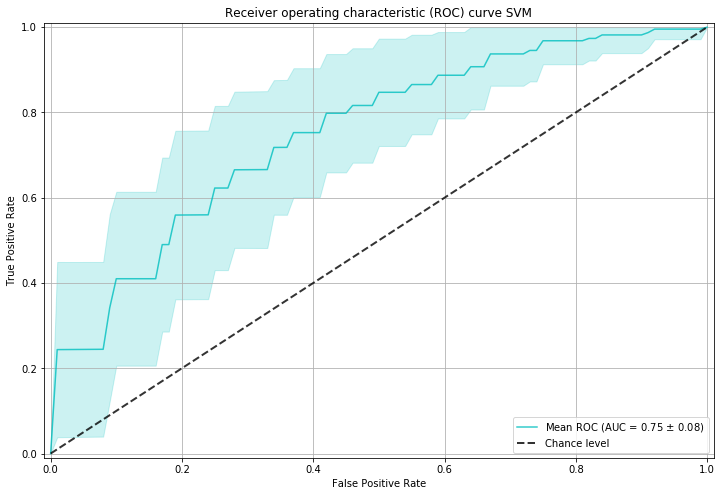

IndexError: list index out of range

In [15]:
# Classifier Pipeline with LASSO 
clsfs = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True)]
names = ['Logistic Regression', 'kNN', 'Random Forest', 'SVM']
param_distributions = [{}, {'n_neighbors': randint(1, 20)}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 17), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]

performance_clf = []
performance_tails = []
for clf, name, param_dist in zip(clsfs, names, param_distributions):
    accuracies = []
    auc_scores = []
    specificities = []
    sensitivities = []
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=None) 
    performance_scores = []
    bas2line_performance = []
    for train_index, test_index in crss_val.split(features, labels):
        x_train, x_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Scale data with Standard Scalar
        x_train, x_test = scale_data(x_train, x_test)

        # Apply LASSO to data
        x_train, x_test = apply_lasso(x_train,y_train, x_test, data_features)

        # RandomSearch for optimalization Hyperparameters
        random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
        model = random_search.fit(x_train, y_train)
        model = model.best_estimator_

        # Evaluate performance Hyperparameters on test set
        performance_scores, tprs, aucs = compute_performance(model, x_test, y_test)

    performance_scores.loc['mean'] = performance_scores.mean()
    
    print(f'Performance {name} Classifier:')
    print(f'{performance_scores.tail(1)}')

    # Plot ROC curves
    plot_ROC(tprs, aucs, name, output_path)
    plt.savefig(str(output_path) + "/" + f'ROC plot{name}.png', dpi=1200)

    performance_clf.append(performance_scores)
    
    # performance_tails.append(performance_scores.tail(1))
    # print(performance_tails)
    
    # performance_test = pd.DataFrame()
    # performance_test['Classifier'] = ['LR', 'KNN', 'RF', 'SVM']
    #print(performance_test)
#   performance_result = pd.merge(performance_test, performance_scores.tail(1), how='inner', on = ['Accuracy', 'AUC', 'Sensitivity', 'Specificity']
    
#    print(performance_result)

# Create boxplot
create_boxplot(performance_clf, names)


4.5 Learning Curves

In [81]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1,1,5)):
    """
    definition to plot learning curve from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    #if axes is None:
    #    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.figure(figsize=(12, 8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes, return_times=True)
 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1,color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best")

    return plt

clsfs = [LogisticRegression(),KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True)]
names = ['LR','kNN', 'Random Forest', 'SVM']
param_distributions = [{}, {'leaf_size': randint(1, 50),
                        'n_neighbors': randint(1, 6), 'p': [1, 2]}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 30), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]


highest_scored_model = []
highest_scored_model_pca = []

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 

for clf, name, param_dist in zip(clsfs, names, param_distributions):
    
    best_models = {}
    best_models_pca = {}
    
    # Scale= features with Standard Scalar
    X = features
    y = labels
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply PCA
    X_pca = pca.fit_transform(X)
    
    # RandomSearch for optimalization Hyperparameters for full dataset
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
    model = random_search.fit(X, y)
    best_model = model.best_estimator_
    best_result = model.best_score_
    best_models[best_model] = best_result
    highest_scored_model = nlargest(1, best_models, key=best_models.get)

    # RandomSearch for optimalization Hyperparameters for PCA dataset
    model_pca = random_search.fit(X_pca, y)
    best_model_pca = model_pca.best_estimator_
    best_result_pca = model_pca.best_score_
    best_models_pca[best_model_pca] = best_result_pca
    highest_scored_model_pca = nlargest(1, best_models_pca, key=best_models_pca.get)

    # Plotting the different learning curves
    fig, axes = plt.subplots(1, 2, figsize=(10, 15))
    plot_learning_curve(highest_scored_model[0], "Learning Curve without feature selection", X, y, axes= 0, ylim=None, cv=cv, n_jobs=None, train_sizes=np.linspace(0.1,1,5))
    plot_learning_curve(highest_scored_model_pca[0], "Learning Curve PCA", X_pca, y, axes=1, ylim=None, cv=cv, n_jobs=None, train_sizes=np.linspace(0.1,1,5))


C:\Users\ylvaw\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ylvaw\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


TypeError: learning_curve() got an unexpected keyword argument 'return_times'